## CNN Using Pytorch
#### Training a CNN Model on image classification for Intel Image Classification
- Dataset link : https://www.kaggle.com/datasets/puneet6060/intel-image-classification


In [1]:
'''
Loading the necessary libraries
'''
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision.transforms import transforms
from torch.autograd import Variable
import torch.functional as F
from PIL import Image
from io import open
from torchvision import datasets, transforms
from PIL import Image
import cv2
import csv
import pandas as pd
from torch import optim
import torch.nn as nn
import torchvision.models as models
import shutil

In [2]:
'''
Checking which device is available (GPU or CPU)
'''
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


#### Image Preprocessing

In [4]:
'''
Transforms Image Preprocessing Pipeline for the images in Training and Testing 
- The settings for resizing the image can be changed for experimentation, feel free to resize however based on the results
'''
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),                     
    transforms.Normalize((0.5,), (0.5,))        
])

###### information about batch size : https://stackoverflow.com/questions/35050753/how-big-should-batch-size-and-number-of-epochs-be-when-fitting-a-model

In [8]:
'''
Load the training and testing dataset 
- Make sure the folder applies the preprocessing transformation to make sure all the image has the same size format and is convert to a tensor
- The batch size for training and testing can be changed for experimentation, but the best performing prediction so far uses 64 batch size for training and testing
'''
train_dataset = datasets.ImageFolder(root = '/location/of/train/dataset', transform=transform)
test_dataset = datasets.ImageFolder(root = '/location/of/test/dataset', transform=transform)

batch_size = 64
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size , shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size , shuffle=False)

In [9]:
'''                        ~ FOR FOURTH MODEL ~
cnn4 achitecture consist of : 
    - 3 Convolutional Layers
    - 3 Pooling Layers
    - 2 Fully Connected Layers
This model takes an image of 224x224 pixel with 3 RGB values
'''
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)          
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, 7)
    
    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model = CNN()
criterion = nn.CrossEntropyLoss()                               
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)         # Adam optimizer is a parameter that can be changed for tuning if necessary

#### Model Training

Before training the model, make sure to set the model in a training mode with the code "model.train()", same goes if you are making evaluation, make sure to set the model to evaluation mode with the code "model.eval()" <\br>
- Both command can show the model's archicture
- Alternatively, if you do not want to change the mode of the model, you can simply just type "model" and it will still show the architecture

In [10]:
model.train()

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=7, bias=True)
)

In [11]:
'''
The parameters in form of lists below is important to keep the values of train and test accuracy, and 
train and test loss to display in a graph
'''
n_epochs = 10               # The number of iteration for training, this value can be changed for experimentation
train_losses = []           
test_losses = []
train_accs = []
test_accs = []

for epoch in range(n_epochs):
    # Training
    train_loss = 0.0
    train_acc = 0.0
    for data, target in train_dataloader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        _, predicted = torch.max(output, 1)
        train_acc += (predicted == target).sum().item()
        
    train_loss /= len(train_dataloader.dataset)
    train_acc /= len(train_dataloader.dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Testing
    test_loss = 0.0
    test_acc = 0.0
    for data, target in test_dataloader:
        output = model(data)
        loss = criterion(output, target)
        test_loss += loss.item() * data.size(0)
        _, predicted = torch.max(output, 1)
        test_acc += (predicted == target).sum().item()
        
    test_loss /= len(test_dataloader.dataset)
    test_acc /= len(test_dataloader.dataset)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    print('Epoch: {}, Training Loss: {:.4f}, Training Accuracy: {:.2f}%, Testing Loss: {:.4f}, Testing Accuracy: {:.2f}%'.format(epoch+1, train_loss, train_acc*100, test_loss, test_acc*100))

Epoch: 1, Training Loss: 0.9619, Training Accuracy: 63.52%, Testing Loss: 0.6815, Testing Accuracy: 74.07%
Epoch: 2, Training Loss: 0.5764, Training Accuracy: 79.12%, Testing Loss: 0.5545, Testing Accuracy: 80.47%
Epoch: 3, Training Loss: 0.4350, Training Accuracy: 84.49%, Testing Loss: 0.5314, Testing Accuracy: 80.97%
Epoch: 4, Training Loss: 0.3098, Training Accuracy: 89.00%, Testing Loss: 0.5596, Testing Accuracy: 81.47%
Epoch: 5, Training Loss: 0.1811, Training Accuracy: 93.81%, Testing Loss: 0.6721, Testing Accuracy: 80.07%
Epoch: 6, Training Loss: 0.1029, Training Accuracy: 96.43%, Testing Loss: 0.7818, Testing Accuracy: 80.80%
Epoch: 7, Training Loss: 0.0556, Training Accuracy: 98.28%, Testing Loss: 0.9668, Testing Accuracy: 78.80%
Epoch: 8, Training Loss: 0.0425, Training Accuracy: 98.85%, Testing Loss: 1.0281, Testing Accuracy: 81.37%
Epoch: 9, Training Loss: 0.0292, Training Accuracy: 99.29%, Testing Loss: 1.0259, Testing Accuracy: 81.33%
Epoch: 10, Training Loss: 0.0409, Tra

In [12]:
'''
Saving the model to a specific location of your choice with the name
- This naming format is set to "ModelName_DataUsed_Accuracy.model"
'''
model_path = 'intel_dataset_98acc_79t.model' 
torch.save(model.state_dict(), model_path)

Plotting the Training and Testing Accuracy, and Training and Testing Loss Graph using the List mentioned in earlier code cell

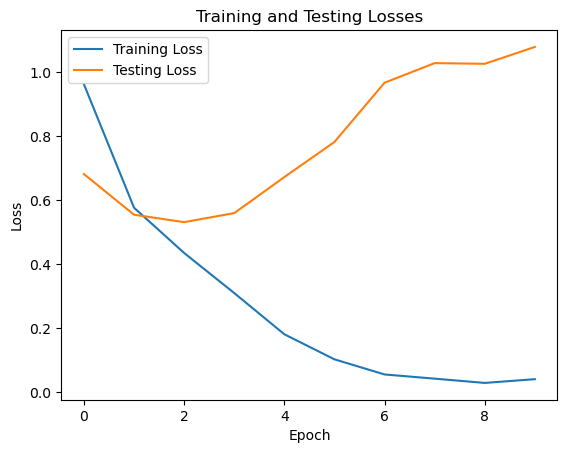

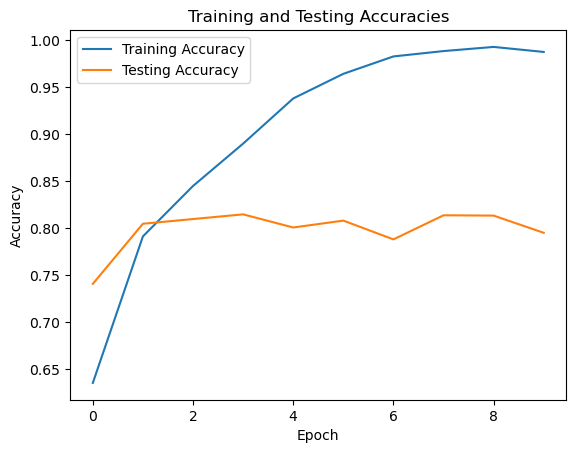

In [13]:
# plot training and testing losses
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Losses')
plt.show()

# plot training and testing accuracies
plt.plot(train_accs, label='Training Accuracy')
plt.plot(test_accs, label='Testing Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracies')
plt.show()